# Bernoulli-Beta Conjugate by MCMC

- We try to produce Figure 6.4 in page 135 of DBDA 2nd.
- Figure 6.4 is obtained by mathematical analysis.
- Here we produce it with MCMC. It should be almost the same. 'Almost' because of sampling approximation.

In [1]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; 
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

In [2]:
rng_key = random.PRNGKey(0)

## With Binomial Likelihood

In [3]:
def model_Binomial(a, b, N, z=17):
    theta = numpyro.sample('theta', dist.Beta(a, b))
    obs = numpyro.sample('obs', dist.Binomial(total_count=N, probs=theta), obs=z)

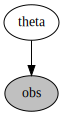

In [4]:
numpyro.render_model(model_Binomial, model_args=(100,100,20,17))

## Run MCMC inference

In [5]:
kernel = NUTS(model_Binomial)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)

#
a,b = 100, 100  # prior model
N, z = 20, 17   # observation from binomial 
#
mcmc.run(rng_key, a=b, b=b, N=N, z=z)
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:06<00:00, 927.10it/s, 1 steps of size 8.86e-01. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.53      0.03      0.53      0.48      0.59   1847.28      1.00

Number of divergences: 0


In [6]:
samples_binom = mcmc.get_samples()
samples = samples_binom
samples

{'theta': DeviceArray([0.59511673, 0.54523164, 0.5446213 , ..., 0.5804791 ,
              0.5676443 , 0.5598417 ], dtype=float32)}

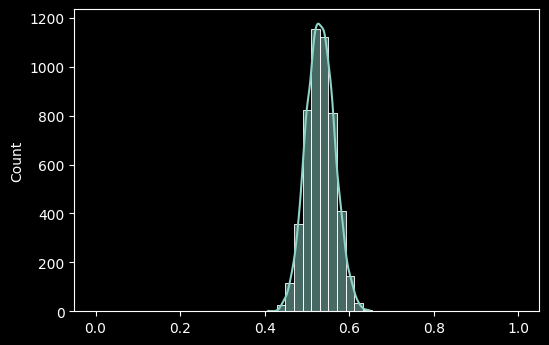

In [7]:
x = np.linspace(0, 1, 50)
sns.histplot(samples['theta'], kde=True, bins=x, );

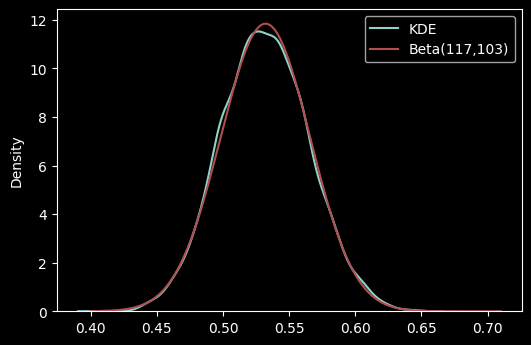

In [8]:
x = np.linspace(.4, .71, 200)
apost, bpost = a+z, b+N-z
pdf = stats.beta.pdf(x, a=apost, b=bpost) # PDF of Beta

ax = sns.kdeplot(samples['theta'])        # KDE of samples
# ax.set(label='KDE')
ax.plot(x, pdf, '-', c='#af4f4f')
ax.legend(['KDE', f'Beta({apost},{bpost})']);

In [9]:
# HDI: High Density Interval
s = samples['theta'].sort()
hdi_prob = .94
p = (1 - hdi_prob)/2
low_index, high_index = int(s.size * p), int(s.size*(1-p))
hdi = (s[low_index].item(), s[high_index].item())
print(f'hdi: [{hdi[0]:.3f}, {hdi[1]:.3f}]')

hdi: [0.471, 0.595]


Mode of Beta(a,b):

$$
    mode = \frac{a-1}{a+b-2} \quad\mbox{for}\quad a,b > 1
$$

In [10]:
# Mode/Peak of the density approximation
import scipy 
kde = scipy.stats.gaussian_kde(s)  # density function approximation
x = np.linspace(0, 1, 1200)
pdfx = kde.evaluate(x) # function values at x
max_index = pdfx.argmax()
print(f'The KDE mode is at     {x[max_index]:.3f}')

mode = (apost - 1) / (apost + bpost - 2)
print(f'Theoretical mode is at {mode}')

The KDE mode is at     0.527
Theoretical mode is at 0.5321100917431193


hdi:  (0.4707302153110504, 0.5951700210571289)


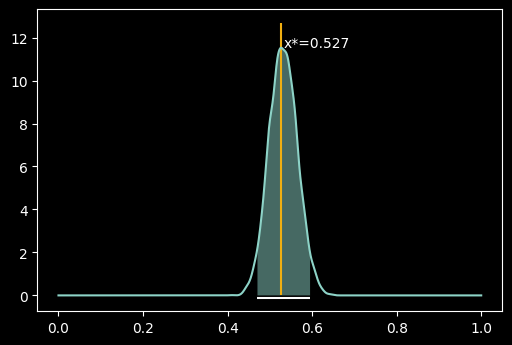

In [11]:
plt.plot(x, pdfx);
plt.vlines(x=x[max_index], ymin=0, ymax=pdfx[max_index]*1.1, colors='#f1af11');
plt.text(x=x[max_index]*1.01, y=pdfx[max_index], s=f'x*={x[max_index]:.3}');
#
plt.hlines(y=-.1, xmin=s[low_index], xmax=s[high_index])
pdfs = kde.evaluate(s)
plt.fill_between(s[low_index:high_index+1], pdfs[low_index:high_index+1], alpha=.5);
#
print('hdi: ', hdi)

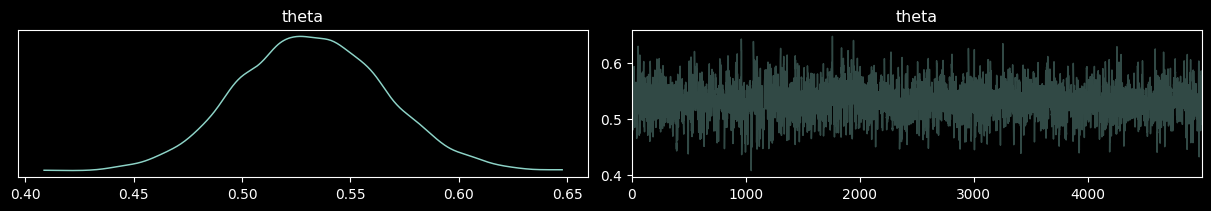

In [12]:
import arviz
arviz.plot_trace(samples);

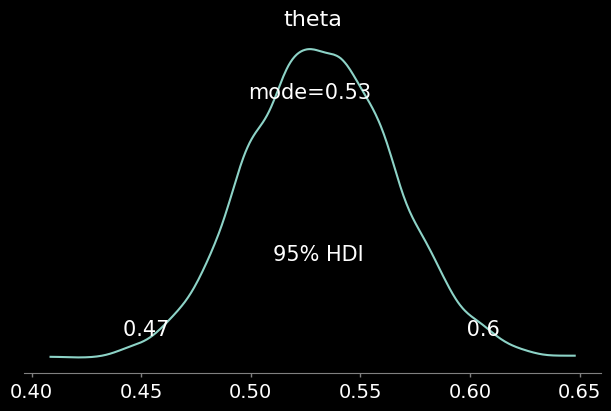

In [13]:
arviz.plot_posterior(samples, point_estimate='mode', bins=x, hdi_prob=.95);

## Posterior Prediction

In [14]:
s1 = samples['theta'][100]  # get a sample of parameter theta
y = stats.binom(n=N, p=s1).rvs(1)  # sample an observation
print('predictive obs: ', y, 'with theta: ', s1)

predictive obs:  [9] with theta:  0.51426417


In [15]:
# we may generate many predictive samples
y = stats.binom(n=N, p=s1).rvs(10000)

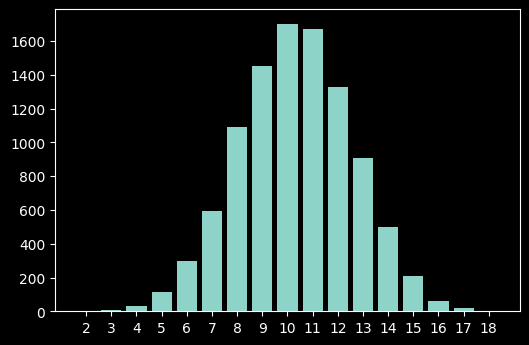

In [16]:
obs, count = np.unique(y, return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

In [17]:
# generate one obs sample for each of the posterior parametr samples
ypost = stats.binom(n=N, p=samples['theta']).rvs()

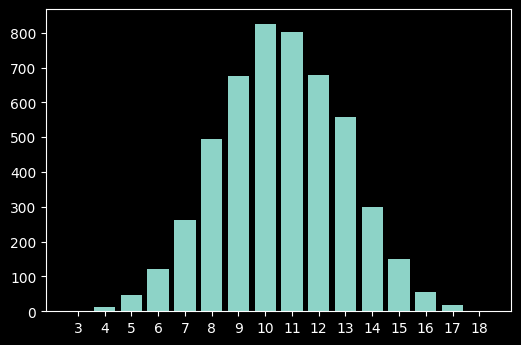

In [18]:
obs, count = np.unique(ypost, return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

- The observation z could have been 10 or 11 or even 6 instead of 17, the actual obs, according to this posterior predictive observation distribution.

**Question**

1. Why is the mode at 11?
2. Plot a prior predictive sampling (observation) distribution. The prior distribution was Beta(100,100) and the sampling distribution was chosen to be Binomial with N=20.
3. See what happens in predictive prior and posterior sampling histograms when the prior is chosen to be Beta(10, 10), N=20, z=17.
4. Repeat for Beta(100, 100), N=200, z=170.

End.

In [19]:
!jupyter nbconvert Ch.6.Bernoulli_beta_Predictive.ipynb --to webpdf --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook Ch.6.Bernoulli_beta_Predictive.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 280955 bytes to Ch.6.Bernoulli_beta_Predictive.pdf
